# Flood Simulation

In [19]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.stats as sts

## Elevation map of Bulgaria

In [4]:
import matplotlib.image as image
import numpy as np
from tqdm import tqdm

# Load the images of the elevation map and color bar.
bulgaria_topography = image.imread('bulgaria_topography_plovdiv.png')
colorbar_image = image.imread('bulgaria_colorbar_small.png')[0]

# Specify the range of values that the colorbar represents. 
colorbar_values = np.linspace(130, 1900, len(colorbar_image))
elevation_bulgaria = np.zeros((len(bulgaria_topography), len(bulgaria_topography[0])))

# Extract the RGB values from the color bar image
colorbar = colorbar_image 

# Traverse all pixels of the topography image.
for y in tqdm(range(len(bulgaria_topography))):
    for x in range(len(bulgaria_topography[0])):
        
        # Initialize the minimum L2 norm b/n the color bar and color of current pixel.
        minimum = float('inf')
        
        # Initialize the index of the color in the color bar. 
        coord = 0
        
        # Traverse the colorbar. 
        for i in range(len(colorbar)):
            
            # Find the minimum L2 norm. 
            if np.linalg.norm(colorbar[i][:3] - bulgaria_topography[y][x][:3]) < minimum:
                minimum = np.linalg.norm(colorbar[i][:3] - bulgaria_topography[y][x][:3])
                coord = i
                
        # Assign the pixel to the closest value of the colorbar. 
        elevation_bulgaria[y][x] = colorbar_values[coord]

100%|██████████| 184/184 [03:14<00:00,  1.06s/it]


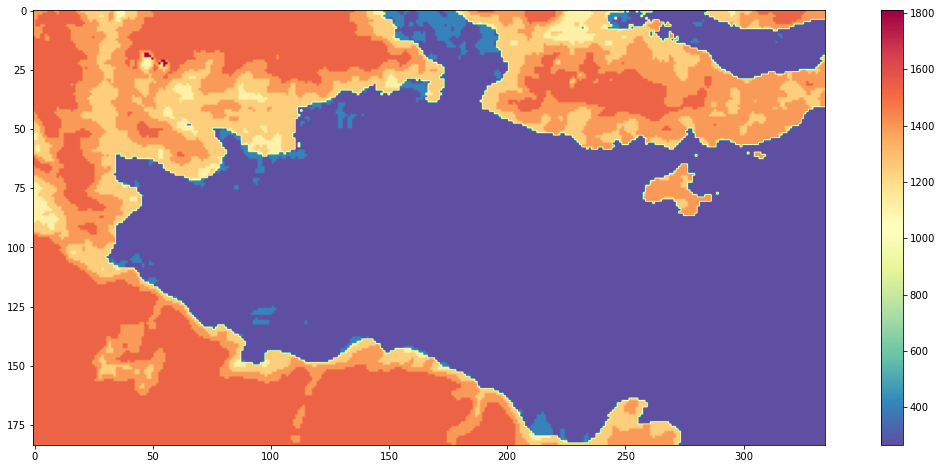

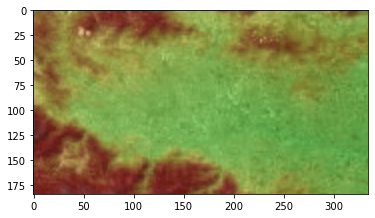

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.imshow(elevation_bulgaria, cmap = 'Spectral_r')
plt.colorbar()
plt.show()
plt.imshow(bulgaria_topography)

Format the matrix as a dictionary so that we can use it later in the flood simulation.

In [78]:
bulgaria_data = [[dict() for i in range(len(elevation_bulgaria[0]))] for i in range(len(elevation_bulgaria))]

for i in range(len(elevation_bulgaria[0])):
    
    for j in range(len(elevation_bulgaria)):
        dictionary = dict()
        dictionary['water_content'] = 0 # at first all cells are empty and dry 
        dictionary['elevation'] = elevation_bulgaria[j][i] # this is inferred from the map
        dictionary['water_capacity'] = 0 # the maximum capacity of water a cell can contain
        dictionary['water_absorption_capacity'] = 0 # water that the ground/soil in that cell can absorb
        
        bulgaria_data[j][i] = dictionary

## Simulation

In [145]:
# I took some of the code and comments from my problem set assignment. 

class FloodSimulation():
    """
    This class defines a simulation for a flooding model using a cellular automaton. 
    
    The rules of the model used to implement the simulation are the following:
    The state of each cell is updated at each time step according to the following rules:
    - If there is water in the current cell, then:
        -  The water in the cells evaporates with a specific rate. 
        -  Find lower elevation neighbors.
        -  For each neighbor
            - Calculate the fraction of water that goes into it. 
            - The neighbors absorbs as much water as it is able to absorb. 
            - If there's remaining water, it gets added to its water content. 
    
    Attributes:
    -----------
    topography: list of dictionaries
        A 2-dimensional matrix that represents the landscape terrain to be modelled. 
        Each cell is represented as a dictionary with the following keys:
            - water_content: The current water in that cell. 
            - elevation: The value of the elevation of that cell. 
            - water_capacity: The maximum capacity of water that the cell can contain.
            - water_absorption_capacity: The water that the c. 
    
    evaporation_rate: float
        The natural water evaporation rate. 
        The average fragment of the water that will evaporate from each cell at each update step. 
    
    water_distribution: list of lists of int
        Represents the state at the current time step of each cell in terms of water content. 
    
    next_water_distribution: float
        Represents the state at the next time step of each cell in terms of water content. 
    
    water_change: list of ints
        Keeps track of the number of times water moved from one cell to another cell at each time step.
        Used to track the dynamics of the system. Used to see if the behavior convereged. 
    
    step_counter: int
        The current step. Simulation (initial state) begins at step 0
    """
    
    def __init__(self, topography, evaporation_rate = 0):
        self.topography = topography
        self.evaporation_rate = evaporation_rate
        
        self.water_distribution = np.zeros((len(self.topography), len(self.topography[0])))
        self.next_water_distribution = np.zeros((len(self.topography), len(self.topography[0])))
        self.water_change = []
        self.step_counter = 0
        
    def initialize(self):
        """ 
        A function that initializes the plot for the animation.
        
        Attributes
        ----------
        None
        
        Returns
        -------
        None
        """
        
        # For plotting the simulation later.   
        self.figure, self.axes = plt.subplots()
        
        
    
    def update(self):
        """ 
        A method that updates the current state to the next state at each step. 
        
        In each cell where there is water:
        - Rule 1: Water evaporation
                The water evaporates according to the evaporation_rate  parameter. 
        - Then we find the lower elevation neighbors of the current cell. 
        - For each of the neighbors, the incoming water towards it is calculated as the appropriate fraction 
        of water coming from the original cell. 
        - Rule 2: Water absorption
                From the incoming water, the neighboring cell can absorb some. The absorption is based on 
            the amount of incoming water, the water absorption rate of the cell, and the maximum water 
            capacity of the cell. It cannot be more than the maximum capacity of the cell so we take 
            the minimum of the water capacity and the incoming water. 
        - Rule 3: Water flow
                The water that remains after rules 1 and 2 gets added to the cell in the next state. 
            The watter that is added to a cell is also added to the elevation on the topography map 
            to account for the water depth on top of the regular terrain. 

        
        Attributes
        ----------
        None
             
             
        Returns
        ----------
        None
        """
        
        # Keep track of the water flow. 
        water_flow = 0
        
        
        # Traverse the whole map. 
        for y in range(len(self.topography)):
            for x in range(len(self.topography[0])):
                    
                # Update cells that contain water. 
                if self.water_distribution[y][x] != 0:
                    
                    ### Rule 1: Evaporate water. 
                    self.water_distribution[y][x] = self.water_distribution[y][x] - self.evaporation_rate*self.water_distribution[y][x]
                    
                    # Initialize a list to store the lower elevation neighbors that should be updated.     
                    neighbors = []
                    
                    
                    # Keep track of the total elevation difference between the current cell and its neighbors.
                    # It's later used to calculate the fraction of water that flows to each neighbor. 
                    elevation_difference = 0
        
                    # Traverse neighborhood with radius 1. 
                    for dy in [-1, 0, 1]:
                        for dx in [-1, 0, 1]:
                            
                            # Not periodic boundary conditions - the map doesn't wrap around, so don't explore those 'neighbors'. 
                            if (x+dx < len(self.topography[0]) and x+dx > -1) and (y+dy < len(self.topography) and y+dy > -1):
                                
                                # Get and store neighbors with lower elevation than the current cell. 
                                if self.topography[y][x]['elevation'] > self.topography[y+dy][x+dx]['elevation']:
                                    current_elevation_difference = self.topography[y][x]['elevation'] - self.topography[y+dy][x+dx]['elevation']
                                    
                                    elevation_difference += current_elevation_difference
                                    
                                    neighbors.append([current_elevation_difference, x+dx, y+dy])
                   
                    # Keep track of the number of times water moves from one cell to another cell.
                    water_flow += len(neighbors)

                    # Update the lower neighbors
#                     self._update_lower_neighbors(neighbors, elevation_difference)

                    # Traverse lower elevation neighbors. 
                    for neighbor in neighbors:

                        # Water that flows into this neighbor. 
                        # It's calculated as the fraction of water that goes from original cell to each neighbor. 
                        incoming_water = self.water_distribution[y][x]*neighbor[0]/elevation_difference

                        ### Rule 2: WATER ABSORBTION.

                        # Water to be absorbed.
                        # It can't exceed the maximum water absorbtion the cell can contain so
                        # we take the minimum of that and the incoming water. 
                        absorbed_water = min(incoming_water, 
                                             self.topography[neighbor[2]][neighbor[1]]['water_absorption_capacity'])

                        # Absorb water - all if possible. 
                        if self.topography[neighbor[2]][neighbor[1]]['water_content'] + absorbed_water < self.topography[neighbor[2]][neighbor[1]]['water_capacity']:
                            self.topography[neighbor[2]][neighbor[1]]['water_content'] += absorbed_water

                        # Absorb water - as much as possible. 
                        else:
                            absorbed_water = self.topography[neighbor[2]][neighbor[1]]['water_capacity'] 
                            absorbed_water -= self.topography[neighbor[2]][neighbor[1]]['water_content']

                            self.topography[neighbor[2]][neighbor[1]]['water_content'] += absorbed_water

                        ### Rule 3: WATER FLOWING.

                        # Water flow - remaining water gets added to the cell in the water distribution. 
                        remaining_water = incoming_water - absorbed_water
                        self.next_water_distribution[neighbor[2]][neighbor[1]] += remaining_water

                        # Account for the water depth by adding it to the elevation on the topography map. 
                        self.topography[neighbor[2]][neighbor[1]]['elevation'] += remaining_water
                        
                    # If the cell gave water to neighbors with lower elevation, then it's empty. 
                    if neighbors:
                        self.next_water_distribution[y][x] = 0
                    else:
                        self.next_water_distribution[y][x] = self.water_distribution[y][x]

                    
        # Update the state to the next state. 
        self.water_distribution = self.next_water_distribution
        
        # Store the water flow changes. 
        self.water_change.append(water_flow)
        
        # Update the step counter. 
        self.step_counter += 1
        
    def _update_lower_neighbors(self, neighbors, elevation_difference):
        """
        An internal method to update the lower neighbors. 
        
        Applies the absorbtion and water flow rules of the model. 
        
        Attributes
        ----------
        neighbors: array
            The array of lower elevation neighbors of a cell.
        
        Returns
        -------
        None
        """
        # Traverse lower elevation neighbors. 
        for neighbor in neighbors:

            # Water that flows into this neighbor. 
            # It's calculated as the fraction of water that goes from original cell to each neighbor. 
            incoming_water = self.water_distribution[y][x]*neighbor[0]/elevation_difference

            ### Rule 2: WATER ABSORBTION.

            # Water to be absorbed.
            # It can't exceed the maximum water absorbtion the cell can contain so
            # we take the minimum of that and the incoming water. 
            absorbed_water = min(incoming_water, 
                                 self.topography[neighbor[2]][neighbor[1]]['water_absorption_capacity'])

            # Absorb water - all if possible. 
            if self.topography[neighbor[2]][neighbor[1]]['water_content'] + absorbed_water < self.topography[neighbor[2]][neighbor[1]]['water_capacity']:
                self.topography[neighbor[2]][neighbor[1]]['water_content'] += absorbed_water

            # Absorb water - as much as possible. 
            else:
                absorbed_water = self.topography[neighbor[2]][neighbor[1]]['water_capacity'] 
                absorbed_water -= self.topography[neighbor[2]][neighbor[1]]['water_content']

                self.topography[neighbor[2]][neighbor[1]]['water_content'] += absorbed_water

            ### Rule 3: WATER FLOWING.

            # Water flow - remaining water gets added to the cell in the water distribution. 
            remaining_water = incoming_water - absorbed_water
            self.next_water_distribution[neighbor[2]][neighbor[1]] += remaining_water

            # Account for the water depth by adding it to the elevation on the topography map. 
            self.topography[neighbor[2]][neighbor[1]]['elevation'] += remaining_water

        # If the cell gave water to neighbors with lower elevation, then it's empty. 
        if neighbors:
            self.next_water_distribution[y][x] = 0
        else:
            self.next_water_distribution[y][x] = self.water_distribution[y][x]
            
        return
    
    def add_water(self, x_coo, y_coo, dist = sts.uniform(3, 3)):
        """ 
        A method used to add water to the landscape topography. 
        
        Parameters
        ----------
         x_coo: tuple of ints
            This represents the start and end coordinates fo the x-axis of the segment
            of topography where we want to add water. 
        y_coo: tuple of ints
            This represents the start and end coordinates fo the axis of the segment
            of topography where we want to add water. 
        dist: scipy.stats instance
            The distribution used to draw a random variable sample to add water to the segment of the topography. 
            Default value: sts.uniform(3, 3)
            
        Returns
        ----------
        None
        """
        
        # Traverse the segment of the terraind and add water to each cell.
        for x in range(x_coo[0], x_coo[1]):
            for y in range(y_coo[0], y_coo[1]):
                self.water_distribution[y][x] += dist.rvs()
    
    def observe(self):
        """ 
        A method used to plot the state of the configuration on the plot at each step. 
        This helps us observe the water distribution in each cell.
        
        Attributes
        ----------
        None
                
        
        Returns
        -------
        None
        """

        plot = self.axes.imshow(self.water_distribution, cmap = 'Blues', vmax = 1) # blue for water 
    
        self.axes.set_title(f'State at step {self.step_counter}')
        return plot

## Test cases

In [88]:
# Water goes down from mountain in left corner. 
sim = FloodSimulation(bulgaria_data)

# Add rain.
sim.add_water((0, 100), (0, 100), sts.uniform(2, 4))

# Update. 
updates = 500
for i in tqdm(range(updates)):
    sim.update()







  0%|          | 0/500 [00:00<?, ?it/s]





  0%|          | 1/500 [00:00<01:01,  8.07it/s]





  1%|          | 4/500 [00:00<00:47, 10.34it/s]





  1%|▏         | 7/500 [00:00<00:38, 12.82it/s]





  2%|▏         | 11/500 [00:00<00:31, 15.54it/s]





  3%|▎         | 14/500 [00:00<00:28, 16.97it/s]





  4%|▎         | 18/500 [00:00<00:24, 19.68it/s]





  4%|▍         | 22/500 [00:00<00:21, 22.02it/s]





  5%|▌         | 25/500 [00:00<00:20, 23.02it/s]





  6%|▌         | 28/500 [00:01<00:19, 24.00it/s]





  6%|▋         | 32/500 [00:01<00:18, 25.72it/s]





  7%|▋         | 35/500 [00:01<00:17, 26.79it/s]





  8%|▊         | 38/500 [00:01<00:16, 27.39it/s]





  8%|▊         | 41/500 [00:01<00:16, 27.90it/s]





  9%|▉         | 45/500 [00:01<00:15, 28.86it/s]





 10%|▉         | 49/500 [00:01<00:15, 29.39it/s]





 10%|█         | 52/500 [00:01<00:15, 29.14it/s]





 11%|█         | 55/500 [00:01<00:15, 28.84it/s]





 12%|█▏        | 58/500 [00:02<00:

 82%|████████▏ | 410/500 [00:13<00:02, 30.99it/s]





 83%|████████▎ | 414/500 [00:13<00:02, 30.65it/s]





 84%|████████▎ | 418/500 [00:13<00:02, 30.51it/s]





 84%|████████▍ | 422/500 [00:14<00:02, 30.40it/s]





 85%|████████▌ | 426/500 [00:14<00:02, 30.03it/s]





 86%|████████▌ | 430/500 [00:14<00:02, 30.02it/s]





 87%|████████▋ | 434/500 [00:14<00:02, 30.15it/s]





 88%|████████▊ | 438/500 [00:14<00:02, 30.55it/s]





 88%|████████▊ | 442/500 [00:14<00:01, 30.43it/s]





 89%|████████▉ | 446/500 [00:14<00:01, 30.28it/s]





 90%|█████████ | 450/500 [00:15<00:01, 30.22it/s]





 91%|█████████ | 454/500 [00:15<00:01, 30.12it/s]





 92%|█████████▏| 458/500 [00:15<00:01, 29.87it/s]





 92%|█████████▏| 461/500 [00:15<00:01, 29.81it/s]





 93%|█████████▎| 465/500 [00:15<00:01, 30.08it/s]





 94%|█████████▍| 469/500 [00:15<00:01, 30.37it/s]





 95%|█████████▍| 473/500 [00:15<00:00, 30.58it/s]





 95%|█████████▌| 477/500 [00:15<00:00, 30.42it/s]





 96%|█████

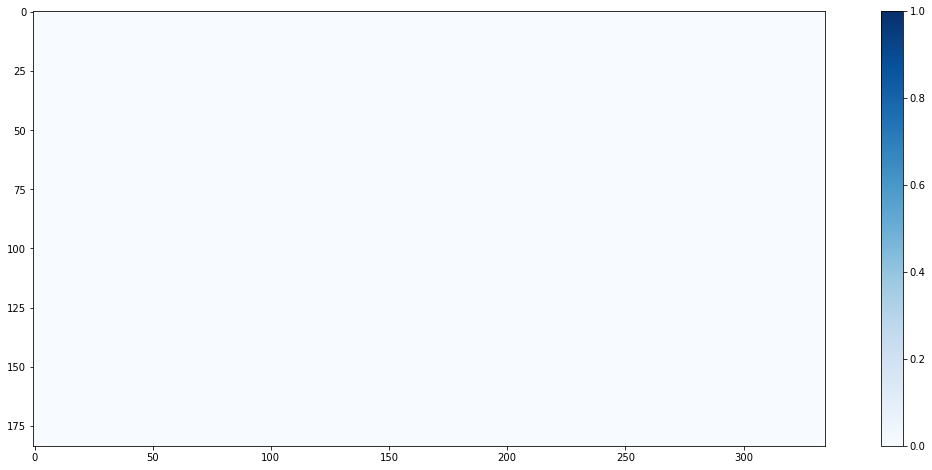

In [89]:
#observing the water distribution after the 600 updates

plt.figure(figsize=(20, 8))
plt.imshow(sim.water_distribution, cmap = 'Blues', vmax = 1)
plt.colorbar()

In [196]:
# Water goes down from mountain in left corner. 
sim = FloodSimulation(bulgaria_data)

# Add rain.
sim.add_water((0, 100), (0, 100), sts.uniform(0, 0.1))

# Update. 
updates = 5
for i in tqdm(range(updates)):
    sim.update()












  0%|          | 0/5 [00:00<?, ?it/s]










 20%|██        | 1/5 [00:00<00:01,  3.96it/s]










 40%|████      | 2/5 [00:00<00:00,  3.48it/s]










 60%|██████    | 3/5 [00:00<00:00,  3.32it/s]










 80%|████████  | 4/5 [00:01<00:00,  3.20it/s]










100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


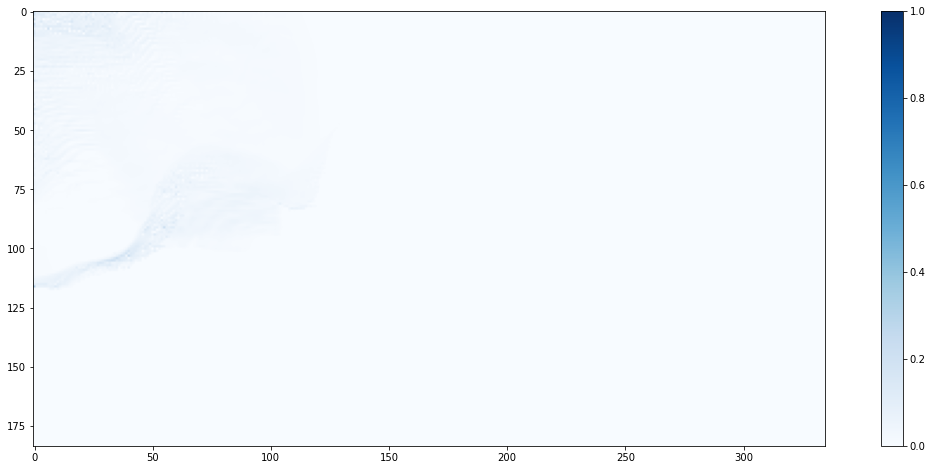

In [197]:
#observing the water distribution after the 600 updates

plt.figure(figsize=(20, 8))
plt.imshow(sim.water_distribution, cmap = 'Blues', vmax = 1)
plt.colorbar()

## Animation function

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def make_animation(sim, total_frames, steps_per_frame=1, interval=100):
    """
    This function creates a visualization for the behavior of the predator prey model. 
    
    Attributes
    ----------
    sim: instance of a class
        The simulation to be visualized
    total_frames: int
        The number of frames we want to visualize
    steps_per_frame: int
        The number of steps (updates of the state of the simulation) per frame 
    interval: int
        Delay between frames in milliseconds
    """
    # Import libraries
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML
    from tqdm import tqdm
    
    def update(frame_number):
        """ This function generates and updates the state of the simulation and plot"""
        for _ in range(steps_per_frame):
            sim.update()
        progress_bar.update(1)
        return [sim.observe()]

    sim.initialize() # initialize the simulation
    progress_bar = tqdm(total=total_frames) # include a progress tracker
    # Make animation
    animation = FuncAnimation(
        sim.figure, update, init_func=lambda: [], frames=total_frames, interval=interval)
    output = HTML(animation.to_html5_video())
    sim.figure.clf()
    return output

In [146]:
sim = FloodSimulation(bulgaria_data)

# Add rain.
sim.add_water((0, 100), (0, 100), sts.uniform(3,3))


In [148]:
make_animation(sim, total_frames=50, steps_per_frame=1)










  0%|          | 0/50 [00:00<?, ?it/s]








  2%|▏         | 1/50 [00:00<00:26,  1.83it/s]








  4%|▍         | 2/50 [00:01<00:28,  1.71it/s]








  6%|▌         | 3/50 [00:01<00:27,  1.68it/s]








  8%|▊         | 4/50 [00:02<00:28,  1.60it/s]








 10%|█         | 5/50 [00:03<00:29,  1.55it/s]








 12%|█▏        | 6/50 [00:03<00:28,  1.52it/s]








 14%|█▍        | 7/50 [00:04<00:31,  1.35it/s]








 16%|█▌        | 8/50 [00:05<00:35,  1.17it/s]








 18%|█▊        | 9/50 [00:06<00:36,  1.14it/s]








 20%|██        | 10/50 [00:07<00:36,  1.10it/s]








 22%|██▏       | 11/50 [00:08<00:35,  1.09it/s]








 24%|██▍       | 12/50 [00:09<00:36,  1.05it/s]








 26%|██▌       | 13/50 [00:10<00:36,  1.03it/s]








 28%|██▊       | 14/50 [00:12<00:36,  1.02s/it]








 30%|███       | 15/50 [00:12<00:35,  1.01s/it]








 32%|███▏      | 16/50 [00:13<00:32,  1.04it/s]








 34%|███▍      | 17/50 [00:14<00:31,  1.06it/s]








 

<Figure size 432x288 with 0 Axes>

## Seeing the trends

In [152]:
# TEST CASE 2 -- add an equal amount of rain to all cells. 
sim = FloodSimulation(bulgaria_data)

# Add rain.
sim.add_water((0, 334), (0, 183), sts.uniform(1,1))


In [153]:
make_animation(sim, total_frames=50, steps_per_frame=10)











  0%|          | 0/50 [00:00<?, ?it/s]









  2%|▏         | 1/50 [00:10<08:43, 10.69s/it]









  4%|▍         | 2/50 [00:21<08:30, 10.63s/it]









  6%|▌         | 3/50 [00:31<08:14, 10.52s/it]









  8%|▊         | 4/50 [00:41<07:59, 10.42s/it]









 10%|█         | 5/50 [00:51<07:43, 10.30s/it]









 12%|█▏        | 6/50 [01:02<07:40, 10.46s/it]









 14%|█▍        | 7/50 [01:13<07:36, 10.63s/it]









 16%|█▌        | 8/50 [01:23<07:24, 10.58s/it]









 18%|█▊        | 9/50 [01:33<07:04, 10.34s/it]









 20%|██        | 10/50 [01:42<06:35,  9.90s/it]









 22%|██▏       | 11/50 [01:51<06:16,  9.65s/it]









 24%|██▍       | 12/50 [02:00<05:53,  9.29s/it]









 26%|██▌       | 13/50 [02:08<05:32,  8.99s/it]









 28%|██▊       | 14/50 [02:16<05:13,  8.72s/it]









 30%|███       | 15/50 [02:24<04:56,  8.46s/it]









 32%|███▏      | 16/50 [02:32<04:42,  8.31s/it]









 34%|███▍      | 17/50 [02:40<04:36,  8

<Figure size 432x288 with 0 Axes>

# Analysis

## Average water flow

In [162]:
# CASE 1 -- add an equal amount of rain to all cells. 
sim = FloodSimulation(bulgaria_data)

# Add rain.
sim.add_water((0, 334), (0, 183), sts.uniform(1,1))


In [170]:
x_axis = []
water_flow = []
for i in tqdm(range(300)):
    sim.update()
    x_axis.append(i)
    
water_flow = sim.water_change 












  0%|          | 0/300 [00:00<?, ?it/s]










  0%|          | 1/300 [00:01<06:51,  1.38s/it]










  1%|          | 2/300 [00:02<06:44,  1.36s/it]










  1%|          | 3/300 [00:04<06:47,  1.37s/it]










  1%|▏         | 4/300 [00:05<06:35,  1.33s/it]










  2%|▏         | 5/300 [00:06<06:35,  1.34s/it]










  2%|▏         | 6/300 [00:08<06:38,  1.35s/it]










  2%|▏         | 7/300 [00:09<06:42,  1.37s/it]










  3%|▎         | 8/300 [00:10<06:41,  1.38s/it]










  3%|▎         | 9/300 [00:12<06:51,  1.41s/it]










  3%|▎         | 10/300 [00:13<06:52,  1.42s/it]










  4%|▎         | 11/300 [00:15<06:37,  1.37s/it]










  4%|▍         | 12/300 [00:16<06:33,  1.37s/it]










  4%|▍         | 13/300 [00:17<06:23,  1.34s/it]










  5%|▍         | 14/300 [00:19<06:23,  1.34s/it]










  5%|▌         | 15/300 [00:20<06:10,  1.30s/it]










  5%|▌         | 16/300 [00:21<06:07,  1.29s/it]










  6%

 30%|██▉       | 89/300 [01:53<04:26,  1.26s/it]










 30%|███       | 90/300 [01:54<04:25,  1.26s/it]










 30%|███       | 91/300 [01:55<04:20,  1.25s/it]










 31%|███       | 92/300 [01:56<04:19,  1.25s/it]










 31%|███       | 93/300 [01:57<04:10,  1.21s/it]










 31%|███▏      | 94/300 [01:59<04:06,  1.20s/it]










 32%|███▏      | 95/300 [02:00<04:10,  1.22s/it]










 32%|███▏      | 96/300 [02:01<04:12,  1.24s/it]










 32%|███▏      | 97/300 [02:03<04:23,  1.30s/it]










 33%|███▎      | 98/300 [02:04<04:11,  1.24s/it]










 33%|███▎      | 99/300 [02:05<04:15,  1.27s/it]










 33%|███▎      | 100/300 [02:06<04:05,  1.23s/it]










 34%|███▎      | 101/300 [02:07<03:57,  1.19s/it]










 34%|███▍      | 102/300 [02:08<03:51,  1.17s/it]










 34%|███▍      | 103/300 [02:10<03:49,  1.17s/it]










 35%|███▍      | 104/300 [02:11<03:43,  1.14s/it]










 35%|███▌      | 105/300 [02:12<03:35,  1.11s/it]



 59%|█████▉    | 177/300 [03:36<02:28,  1.21s/it]










 59%|█████▉    | 178/300 [03:37<02:26,  1.20s/it]










 60%|█████▉    | 179/300 [03:38<02:24,  1.20s/it]










 60%|██████    | 180/300 [03:39<02:23,  1.20s/it]










 60%|██████    | 181/300 [03:41<02:25,  1.22s/it]










 61%|██████    | 182/300 [03:42<02:21,  1.20s/it]










 61%|██████    | 183/300 [03:43<02:20,  1.20s/it]










 61%|██████▏   | 184/300 [03:44<02:18,  1.20s/it]










 62%|██████▏   | 185/300 [03:45<02:19,  1.22s/it]










 62%|██████▏   | 186/300 [03:47<02:17,  1.21s/it]










 62%|██████▏   | 187/300 [03:48<02:16,  1.21s/it]










 63%|██████▎   | 188/300 [03:49<02:14,  1.20s/it]










 63%|██████▎   | 189/300 [03:50<02:19,  1.25s/it]










 63%|██████▎   | 190/300 [03:52<02:20,  1.27s/it]










 64%|██████▎   | 191/300 [03:53<02:18,  1.27s/it]










 64%|██████▍   | 192/300 [03:54<02:15,  1.26s/it]










 64%|██████▍   | 193/300 [03:55<02:13,  

 88%|████████▊ | 265/300 [05:26<00:44,  1.27s/it]










 89%|████████▊ | 266/300 [05:27<00:42,  1.25s/it]










 89%|████████▉ | 267/300 [05:28<00:41,  1.26s/it]










 89%|████████▉ | 268/300 [05:30<00:39,  1.24s/it]










 90%|████████▉ | 269/300 [05:31<00:38,  1.25s/it]










 90%|█████████ | 270/300 [05:32<00:37,  1.26s/it]










 90%|█████████ | 271/300 [05:33<00:36,  1.25s/it]










 91%|█████████ | 272/300 [05:35<00:34,  1.24s/it]










 91%|█████████ | 273/300 [05:36<00:33,  1.24s/it]










 91%|█████████▏| 274/300 [05:37<00:32,  1.24s/it]










 92%|█████████▏| 275/300 [05:39<00:32,  1.30s/it]










 92%|█████████▏| 276/300 [05:40<00:31,  1.30s/it]










 92%|█████████▏| 277/300 [05:41<00:29,  1.27s/it]










 93%|█████████▎| 278/300 [05:42<00:28,  1.28s/it]










 93%|█████████▎| 279/300 [05:44<00:26,  1.26s/it]










 93%|█████████▎| 280/300 [05:45<00:24,  1.24s/it]










 94%|█████████▎| 281/300 [05:46<00:23,  

Text(0.5, 1.0, 'Average water flow')

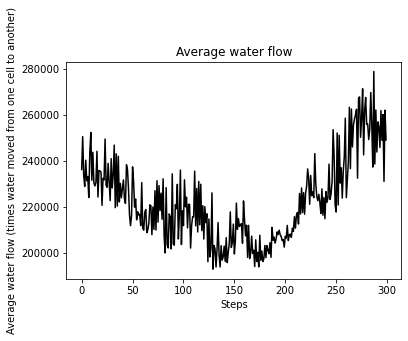

In [177]:
import matplotlib.pyplot as plt
plt.plot(x_axis, water_flow[:300], color = 'black')
plt.xlabel('Steps')
plt.ylabel('Average water flow (times water moved from one cell to another)')
plt.title("Average water flow")

# Water depth

There is no known threshold for when to consider something an urban flood. I will consider that there is an urban flooding if the water depth of the Plovdiv Province exceeds 0.3 meters at any point. 


In [198]:
# CASE 1 -- add an equal amount of rain to all cells. 
sim = FloodSimulation(bulgaria_data)

# Add rain.
sim.add_water((0, 334), (0, 183), sts.uniform(0,0.1))

In [199]:
x_axis = []
water_depth = []
for i in tqdm(range(300)):
    sim.update()
    
    current_water_depths = 0 
    for y in range(75,125):
        for x in range(100, 250):
            current_water_depths += sim.water_distribution[y][x]
            
    water_depth.append(current_water_depths/(150*50))
    
    x_axis.append(i)
    
water_flow = sim.water_change 












  0%|          | 0/300 [00:00<?, ?it/s]










  0%|          | 1/300 [00:01<06:22,  1.28s/it]










  1%|          | 2/300 [00:02<06:24,  1.29s/it]










  1%|          | 3/300 [00:03<06:23,  1.29s/it]










  1%|▏         | 4/300 [00:05<06:22,  1.29s/it]










  2%|▏         | 5/300 [00:06<06:33,  1.33s/it]










  2%|▏         | 6/300 [00:07<06:29,  1.33s/it]










  2%|▏         | 7/300 [00:09<06:25,  1.31s/it]










  3%|▎         | 8/300 [00:10<06:27,  1.33s/it]










  3%|▎         | 9/300 [00:11<06:19,  1.31s/it]










  3%|▎         | 10/300 [00:13<06:13,  1.29s/it]










  4%|▎         | 11/300 [00:14<06:08,  1.28s/it]










  4%|▍         | 12/300 [00:15<06:00,  1.25s/it]










  4%|▍         | 13/300 [00:16<05:51,  1.23s/it]










  5%|▍         | 14/300 [00:17<05:47,  1.22s/it]










  5%|▌         | 15/300 [00:19<05:43,  1.20s/it]










  5%|▌         | 16/300 [00:20<05:40,  1.20s/it]










  6%

 30%|██▉       | 89/300 [01:45<04:13,  1.20s/it]










 30%|███       | 90/300 [01:46<04:16,  1.22s/it]










 30%|███       | 91/300 [01:48<04:09,  1.19s/it]










 31%|███       | 92/300 [01:49<04:03,  1.17s/it]










 31%|███       | 93/300 [01:50<03:58,  1.15s/it]










 31%|███▏      | 94/300 [01:51<03:57,  1.15s/it]










 32%|███▏      | 95/300 [01:52<03:54,  1.14s/it]










 32%|███▏      | 96/300 [01:53<03:53,  1.14s/it]










 32%|███▏      | 97/300 [01:54<03:53,  1.15s/it]










 33%|███▎      | 98/300 [01:56<03:51,  1.15s/it]










 33%|███▎      | 99/300 [01:57<03:50,  1.15s/it]










 33%|███▎      | 100/300 [01:58<03:46,  1.13s/it]










 34%|███▎      | 101/300 [01:59<03:45,  1.13s/it]










 34%|███▍      | 102/300 [02:00<03:43,  1.13s/it]










 34%|███▍      | 103/300 [02:01<03:42,  1.13s/it]










 35%|███▍      | 104/300 [02:02<03:40,  1.13s/it]










 35%|███▌      | 105/300 [02:03<03:38,  1.12s/it]



 59%|█████▉    | 177/300 [03:26<02:20,  1.14s/it]










 59%|█████▉    | 178/300 [03:27<02:16,  1.12s/it]










 60%|█████▉    | 179/300 [03:28<02:15,  1.12s/it]










 60%|██████    | 180/300 [03:29<02:15,  1.13s/it]










 60%|██████    | 181/300 [03:31<02:17,  1.15s/it]










 61%|██████    | 182/300 [03:32<02:14,  1.14s/it]










 61%|██████    | 183/300 [03:33<02:14,  1.15s/it]










 61%|██████▏   | 184/300 [03:34<02:13,  1.15s/it]










 62%|██████▏   | 185/300 [03:35<02:09,  1.13s/it]










 62%|██████▏   | 186/300 [03:36<02:07,  1.12s/it]










 62%|██████▏   | 187/300 [03:37<02:03,  1.10s/it]










 63%|██████▎   | 188/300 [03:38<02:03,  1.10s/it]










 63%|██████▎   | 189/300 [03:40<02:01,  1.09s/it]










 63%|██████▎   | 190/300 [03:41<01:59,  1.09s/it]










 64%|██████▎   | 191/300 [03:42<01:58,  1.09s/it]










 64%|██████▍   | 192/300 [03:43<01:57,  1.09s/it]










 64%|██████▍   | 193/300 [03:44<01:56,  

 88%|████████▊ | 265/300 [08:38<00:37,  1.07s/it]










 89%|████████▊ | 266/300 [08:39<00:35,  1.06s/it]










 89%|████████▉ | 267/300 [08:40<00:34,  1.04s/it]










 89%|████████▉ | 268/300 [08:41<00:32,  1.02s/it]










 90%|████████▉ | 269/300 [08:42<00:32,  1.05s/it]










 90%|█████████ | 270/300 [08:43<00:32,  1.07s/it]










 90%|█████████ | 271/300 [08:44<00:30,  1.05s/it]










 91%|█████████ | 272/300 [08:45<00:29,  1.06s/it]










 91%|█████████ | 273/300 [08:46<00:28,  1.04s/it]










 91%|█████████▏| 274/300 [08:47<00:26,  1.04s/it]










 92%|█████████▏| 275/300 [08:48<00:25,  1.02s/it]










 92%|█████████▏| 276/300 [08:50<00:24,  1.02s/it]










 92%|█████████▏| 277/300 [08:51<00:23,  1.02s/it]










 93%|█████████▎| 278/300 [08:52<00:22,  1.03s/it]










 93%|█████████▎| 279/300 [08:53<00:22,  1.06s/it]










 93%|█████████▎| 280/300 [08:54<00:21,  1.06s/it]










 94%|█████████▎| 281/300 [08:55<00:20,  

Text(0.5, 1.0, 'Average water depth')

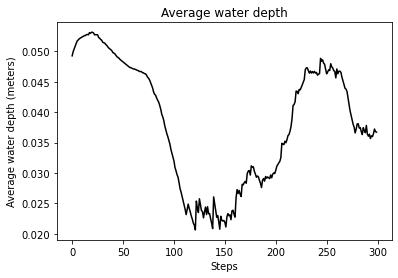

In [200]:
import matplotlib.pyplot as plt
plt.plot(x_axis, water_depth[:300], color = 'black')
plt.xlabel('Steps')
plt.ylabel('Average water depth (meters)')
plt.title("Average water depth")

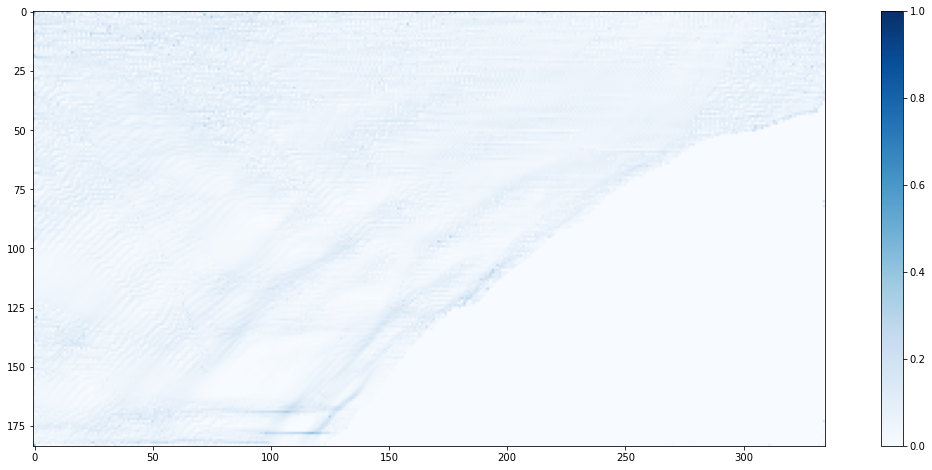

In [201]:
#observing the water distribution after the 600 updates

plt.figure(figsize=(20, 8))
plt.imshow(sim.water_distribution, cmap = 'Blues', vmax = 1)
plt.colorbar()

In [203]:
# TEST CASE 2 -- add an equal amount of rain to all cells. 
sim = FloodSimulation(bulgaria_data)

# Add rain.
sim.add_water((0, 334), (0, 183), sts.uniform(0,0.1))

make_animation(sim, total_frames=30, steps_per_frame=10)













  0%|          | 0/30 [00:00<?, ?it/s]











  3%|▎         | 1/30 [00:13<06:19, 13.09s/it]











  7%|▋         | 2/30 [00:26<06:08, 13.15s/it]











 10%|█         | 3/30 [00:38<05:50, 12.97s/it]











 13%|█▎        | 4/30 [00:54<05:57, 13.76s/it]











 17%|█▋        | 5/30 [01:06<05:34, 13.37s/it]











 20%|██        | 6/30 [01:19<05:13, 13.08s/it]











 23%|██▎       | 7/30 [01:32<04:59, 13.01s/it]











 27%|██▋       | 8/30 [01:45<04:46, 13.04s/it]











 30%|███       | 9/30 [02:00<04:45, 13.61s/it]











 33%|███▎      | 10/30 [02:14<04:37, 13.85s/it]











 37%|███▋      | 11/30 [02:30<04:33, 14.40s/it]











 40%|████      | 12/30 [02:51<04:56, 16.45s/it]











 43%|████▎     | 13/30 [03:06<04:30, 15.94s/it]











 47%|████▋     | 14/30 [03:27<04:38, 17.43s/it]











 50%|█████     | 15/30 [03:41<04:08, 16.57s/it]











 53%|█████▎    | 16/30 [03:54<03:36, 15.48s/it]











 57

<Figure size 432x288 with 0 Axes>

## Average water depth distribution

In [204]:
average_water_depth_distribution = []

trials = 30
for i in range(trials):
    sim = FloodSimulation(bulgaria_data)

    # Add rain.
    sim.add_water((0, 334), (0, 183), sts.uniform(0,0.1))
    
    updates = 30
    for i in range(updates):
        sim.update()
    
    current_water_depths = 0 
    for y in range(75,125):
        for x in range(100, 250):
            current_water_depths += sim.water_distribution[y][x]

    average_water_depth_distribution.append(current_water_depths/(150*50))

Text(0.5, 1.0, 'Average water depth distribution')

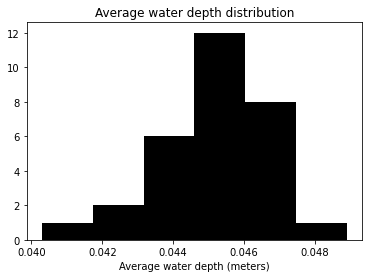

In [210]:
import matplotlib.pyplot as plt
plt.hist(average_water_depth_distribution, color = 'black', bins = 6)
plt.xlabel('Average water depth (meters)')
plt.title("Average water depth distribution")

In [226]:
confidence_interval = (np.mean(average_water_depth_distribution) - 1.96*np.std(average_water_depth_distribution)/(30**0.5), np.mean(average_water_depth_distribution) + 1.96*np.std(average_water_depth_distribution)/(30**0.5))
print("Confidence interval", confidence_interval)
print("Mean", np.mean(average_water_depth_distribution))



Confidence interval (0.04461797893038399, 0.04576775082765507)
Mean 0.04519286487901953


# Intervention: Sponge City Strategy

In [233]:
import copy
bulgaria_data_sponge = copy.deepcopy(bulgaria_data)

for y in range(75,125):
    for x in range(100, 250):
        dictionary['water_capacity'] = 1 # the maximum capacity of water a cell can contain
        bulgaria_data_sponge[y][x]['water_absorption_capacity'] = 1 # water that the ground/soil in that cell can absorb

## Average water flow with intervention

In [234]:
# CASE 1 -- add an equal amount of rain to all cells. 
sim = FloodSimulation(bulgaria_data_sponge)

# Add rain.
sim.add_water((0, 334), (0, 183), sts.uniform(1,1))


In [235]:
x_axis = []
water_flow = []
for i in tqdm(range(300)):
    sim.update()
    x_axis.append(i)
    
water_flow = sim.water_change 














  0%|          | 0/300 [00:00<?, ?it/s]












  0%|          | 1/300 [00:01<07:24,  1.49s/it]












  1%|          | 2/300 [00:03<07:37,  1.54s/it]












  1%|          | 3/300 [00:04<07:38,  1.54s/it]












  1%|▏         | 4/300 [00:06<07:38,  1.55s/it]












  2%|▏         | 5/300 [00:07<07:28,  1.52s/it]












  2%|▏         | 6/300 [00:09<07:11,  1.47s/it]












  2%|▏         | 7/300 [00:10<07:15,  1.48s/it]












  3%|▎         | 8/300 [00:12<07:13,  1.48s/it]












  3%|▎         | 9/300 [00:13<06:53,  1.42s/it]












  3%|▎         | 10/300 [00:14<06:37,  1.37s/it]












  4%|▎         | 11/300 [00:16<06:47,  1.41s/it]












  4%|▍         | 12/300 [00:17<06:27,  1.35s/it]












  4%|▍         | 13/300 [00:18<06:18,  1.32s/it]












  5%|▍         | 14/300 [00:19<06:04,  1.28s/it]












  5%|▌         | 15/300 [00:21<06:03,  1.28s/it]












  5%|▌         | 16/300 [00:2

 27%|██▋       | 82/300 [01:59<05:49,  1.61s/it]












 28%|██▊       | 83/300 [02:00<05:33,  1.54s/it]












 28%|██▊       | 84/300 [02:01<05:23,  1.50s/it]












 28%|██▊       | 85/300 [02:03<05:15,  1.47s/it]












 29%|██▊       | 86/300 [02:04<05:16,  1.48s/it]












 29%|██▉       | 87/300 [02:06<05:28,  1.54s/it]












 29%|██▉       | 88/300 [02:07<05:26,  1.54s/it]












 30%|██▉       | 89/300 [02:09<05:22,  1.53s/it]












 30%|███       | 90/300 [02:10<05:17,  1.51s/it]












 30%|███       | 91/300 [02:12<05:09,  1.48s/it]












 31%|███       | 92/300 [02:13<05:07,  1.48s/it]












 31%|███       | 93/300 [02:15<05:00,  1.45s/it]












 31%|███▏      | 94/300 [02:16<05:06,  1.49s/it]












 32%|███▏      | 95/300 [02:18<05:01,  1.47s/it]












 32%|███▏      | 96/300 [02:19<05:05,  1.50s/it]












 32%|███▏      | 97/300 [02:21<05:01,  1.48s/it]












 33%|███▎      | 98/300 

 54%|█████▍    | 163/300 [03:57<03:32,  1.55s/it]












 55%|█████▍    | 164/300 [03:59<03:39,  1.62s/it]












 55%|█████▌    | 165/300 [04:00<03:27,  1.54s/it]












 55%|█████▌    | 166/300 [04:02<03:28,  1.56s/it]












 56%|█████▌    | 167/300 [04:03<03:27,  1.56s/it]












 56%|█████▌    | 168/300 [04:05<03:31,  1.60s/it]












 56%|█████▋    | 169/300 [04:07<03:30,  1.61s/it]












 57%|█████▋    | 170/300 [04:08<03:22,  1.56s/it]












 57%|█████▋    | 171/300 [04:09<03:15,  1.51s/it]












 57%|█████▋    | 172/300 [04:11<03:13,  1.52s/it]












 58%|█████▊    | 173/300 [04:12<03:07,  1.48s/it]












 58%|█████▊    | 174/300 [04:14<03:04,  1.47s/it]












 58%|█████▊    | 175/300 [04:15<03:01,  1.45s/it]












 59%|█████▊    | 176/300 [04:16<02:53,  1.40s/it]












 59%|█████▉    | 177/300 [04:18<02:54,  1.42s/it]












 59%|█████▉    | 178/300 [04:19<02:50,  1.40s/it]












 60%|███

 81%|████████▏ | 244/300 [06:02<01:24,  1.51s/it]












 82%|████████▏ | 245/300 [06:04<01:23,  1.52s/it]












 82%|████████▏ | 246/300 [06:06<01:23,  1.54s/it]












 82%|████████▏ | 247/300 [06:07<01:22,  1.55s/it]












 83%|████████▎ | 248/300 [06:09<01:24,  1.62s/it]












 83%|████████▎ | 249/300 [06:11<01:26,  1.70s/it]












 83%|████████▎ | 250/300 [06:13<01:26,  1.73s/it]












 84%|████████▎ | 251/300 [06:14<01:23,  1.70s/it]












 84%|████████▍ | 252/300 [06:16<01:21,  1.71s/it]












 84%|████████▍ | 253/300 [06:18<01:24,  1.80s/it]












 85%|████████▍ | 254/300 [06:20<01:21,  1.77s/it]












 85%|████████▌ | 255/300 [06:22<01:20,  1.80s/it]












 85%|████████▌ | 256/300 [06:23<01:19,  1.81s/it]












 86%|████████▌ | 257/300 [06:25<01:14,  1.72s/it]












 86%|████████▌ | 258/300 [06:26<01:09,  1.65s/it]












 86%|████████▋ | 259/300 [06:28<01:05,  1.61s/it]












 87%|███

Text(0.5, 1.0, 'Average water flow (with intervention)')

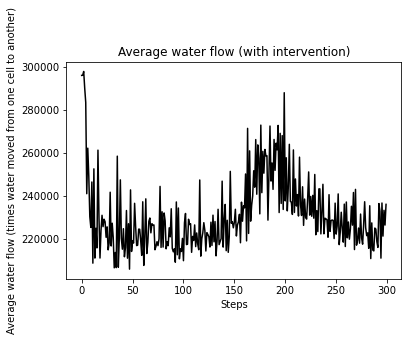

In [236]:
import matplotlib.pyplot as plt
plt.plot(x_axis, water_flow[:300], color = 'black')
plt.xlabel('Steps')
plt.ylabel('Average water flow (times water moved from one cell to another)')
plt.title("Average water flow (with intervention)")

## Average water depth

In [237]:
# CASE 1 -- add an equal amount of rain to all cells. 
sim = FloodSimulation(bulgaria_data_sponge)

# Add rain.
sim.add_water((0, 334), (0, 183), sts.uniform(0,0.1))

In [238]:
x_axis = []
water_depth = []
for i in tqdm(range(300)):
    sim.update()
    
    current_water_depths = 0 
    for y in range(75,125):
        for x in range(100, 250):
            current_water_depths += sim.water_distribution[y][x]
            
    water_depth.append(current_water_depths/(150*50))
    
    x_axis.append(i)
    
water_flow = sim.water_change 














  0%|          | 0/300 [00:00<?, ?it/s]












  0%|          | 1/300 [00:01<06:15,  1.26s/it]












  1%|          | 2/300 [00:02<06:14,  1.26s/it]












  1%|          | 3/300 [00:03<06:11,  1.25s/it]












  1%|▏         | 4/300 [00:05<06:11,  1.26s/it]












  2%|▏         | 5/300 [00:06<06:08,  1.25s/it]












  2%|▏         | 6/300 [00:07<06:10,  1.26s/it]












  2%|▏         | 7/300 [00:08<06:08,  1.26s/it]












  3%|▎         | 8/300 [00:10<06:07,  1.26s/it]












  3%|▎         | 9/300 [00:11<06:04,  1.25s/it]












  3%|▎         | 10/300 [00:12<06:00,  1.24s/it]












  4%|▎         | 11/300 [00:13<05:58,  1.24s/it]












  4%|▍         | 12/300 [00:15<06:02,  1.26s/it]












  4%|▍         | 13/300 [00:16<06:13,  1.30s/it]












  5%|▍         | 14/300 [00:17<06:28,  1.36s/it]












  5%|▌         | 15/300 [00:19<06:29,  1.37s/it]












  5%|▌         | 16/300 [00:2

 27%|██▋       | 82/300 [01:45<04:32,  1.25s/it]












 28%|██▊       | 83/300 [01:46<04:30,  1.25s/it]












 28%|██▊       | 84/300 [01:47<04:28,  1.24s/it]












 28%|██▊       | 85/300 [01:48<04:26,  1.24s/it]












 29%|██▊       | 86/300 [01:50<04:26,  1.25s/it]












 29%|██▉       | 87/300 [01:51<04:32,  1.28s/it]












 29%|██▉       | 88/300 [01:52<04:32,  1.29s/it]












 30%|██▉       | 89/300 [01:53<04:27,  1.27s/it]












 30%|███       | 90/300 [01:55<04:24,  1.26s/it]












 30%|███       | 91/300 [01:56<04:25,  1.27s/it]












 31%|███       | 92/300 [01:57<04:21,  1.26s/it]












 31%|███       | 93/300 [01:58<04:17,  1.24s/it]












 31%|███▏      | 94/300 [02:00<04:16,  1.24s/it]












 32%|███▏      | 95/300 [02:01<04:19,  1.27s/it]












 32%|███▏      | 96/300 [02:02<04:16,  1.26s/it]












 32%|███▏      | 97/300 [02:04<04:20,  1.28s/it]












 33%|███▎      | 98/300 

 54%|█████▍    | 163/300 [03:39<03:15,  1.43s/it]












 55%|█████▍    | 164/300 [03:40<03:09,  1.39s/it]












 55%|█████▌    | 165/300 [03:41<03:07,  1.39s/it]












 55%|█████▌    | 166/300 [03:43<03:04,  1.38s/it]












 56%|█████▌    | 167/300 [03:44<03:03,  1.38s/it]












 56%|█████▌    | 168/300 [03:46<03:01,  1.38s/it]












 56%|█████▋    | 169/300 [03:47<03:01,  1.38s/it]












 57%|█████▋    | 170/300 [03:48<03:01,  1.40s/it]












 57%|█████▋    | 171/300 [03:50<02:58,  1.38s/it]












 57%|█████▋    | 172/300 [03:51<02:57,  1.39s/it]












 58%|█████▊    | 173/300 [03:52<02:52,  1.36s/it]












 58%|█████▊    | 174/300 [03:54<02:51,  1.36s/it]












 58%|█████▊    | 175/300 [03:55<02:47,  1.34s/it]












 59%|█████▊    | 176/300 [03:57<02:49,  1.37s/it]












 59%|█████▉    | 177/300 [03:58<02:46,  1.36s/it]












 59%|█████▉    | 178/300 [03:59<02:46,  1.36s/it]












 60%|███

 81%|████████▏ | 244/300 [05:31<01:17,  1.39s/it]












 82%|████████▏ | 245/300 [05:32<01:16,  1.40s/it]












 82%|████████▏ | 246/300 [05:34<01:15,  1.41s/it]












 82%|████████▏ | 247/300 [05:35<01:14,  1.40s/it]












 83%|████████▎ | 248/300 [05:36<01:11,  1.37s/it]












 83%|████████▎ | 249/300 [05:38<01:12,  1.41s/it]












 83%|████████▎ | 250/300 [05:39<01:09,  1.39s/it]












 84%|████████▎ | 251/300 [05:40<01:06,  1.35s/it]












 84%|████████▍ | 252/300 [05:42<01:04,  1.34s/it]












 84%|████████▍ | 253/300 [05:43<01:03,  1.35s/it]












 85%|████████▍ | 254/300 [05:44<01:03,  1.38s/it]












 85%|████████▌ | 255/300 [05:46<01:02,  1.39s/it]












 85%|████████▌ | 256/300 [05:47<01:02,  1.42s/it]












 86%|████████▌ | 257/300 [05:49<01:00,  1.42s/it]












 86%|████████▌ | 258/300 [05:50<00:59,  1.41s/it]












 86%|████████▋ | 259/300 [05:52<00:58,  1.42s/it]












 87%|███

Text(0.5, 1.0, 'Average water depth')

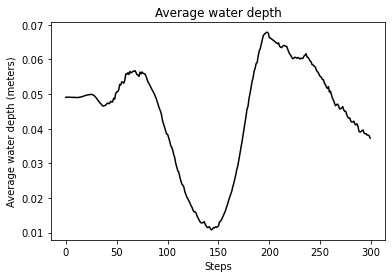

In [239]:
import matplotlib.pyplot as plt
plt.plot(x_axis, water_depth[:300], color = 'black')
plt.xlabel('Steps')
plt.ylabel('Average water depth (meters)')
plt.title("Average water depth")

## Average water depth distribution

In [240]:
average_water_depth_distribution = []

trials = 30
for i in range(trials):
    sim = FloodSimulation(bulgaria_data_sponge)

    # Add rain.
    sim.add_water((0, 334), (0, 183), sts.uniform(0,0.1))
    
    updates = 30
    for i in range(updates):
        sim.update()
    
    current_water_depths = 0 
    for y in range(75,125):
        for x in range(100, 250):
            current_water_depths += sim.water_distribution[y][x]

    average_water_depth_distribution.append(current_water_depths/(150*50))

Text(0.5, 1.0, 'Average water depth distribution')

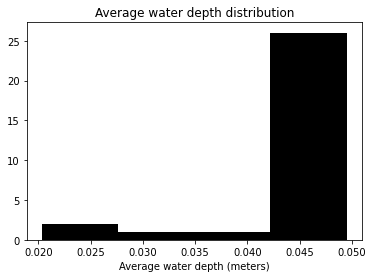

In [244]:
import matplotlib.pyplot as plt
plt.hist(average_water_depth_distribution, color = 'black', bins = 4)
plt.xlabel('Average water depth (meters)')
plt.title("Average water depth distribution")

In [245]:
confidence_interval = (np.mean(average_water_depth_distribution) - 1.96*np.std(average_water_depth_distribution)/(30**0.5), np.mean(average_water_depth_distribution) + 1.96*np.std(average_water_depth_distribution)/(30**0.5))
print("Confidence interval", confidence_interval)
print("Mean", np.mean(average_water_depth_distribution))



Confidence interval (0.04081489497505994, 0.04541721181815388)
Mean 0.04311605339660691


# Renormalization: Theoretical Analysis

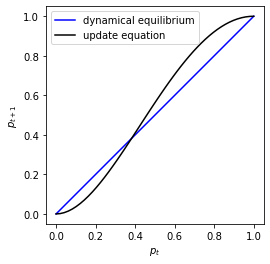

In [246]:
# Code adapted from session 8. 
# https://sle-collaboration.minervaproject.com/?id=4287013b-d120-4374-876d-9f6ce8f39590&userId=10834&name=Vicki+Petrova&avatar=https%3A//s3.amazonaws.com/picasso.fixtures/Victoria_Petrova_10834_2020-09-11T21%3A29%3A05.741Z&isInstructor=0&signature=8cd8fbe71169d0e321e4ed7b6c7499230c77711fcf7de2847610b180184a4271
import pylab

def update_equation(p):
    return p**4 + 4*(p**3)*(1-p) + 4*(p**2)*(1-p)**2

pylab.figure()
p = pylab.linspace(0, 1)
pylab.plot(p, p, 'k', c='blue', label = 'dynamical equilibrium')
pylab.plot(p, update_equation(p), 'k', label='update equation')
pylab.axis('square')
pylab.xlabel('$p_t$') # p_s?
pylab.ylabel('$p_{t+1}$') # p_2s?
pylab.legend()
pylab.show()